## Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc, math

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

/Users/praveengovindaraj/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def degToCompass(num):
    val=int((num/22.5)+.5)
    arr=[i for i in range(0,16)]
    return arr[(val % 16)]

## Reading feature engineered dataset

In [3]:
# Save the testing dataset to freeup the RAM. We'll read after training
full_test_df = pd.read_pickle('tmp/full_test_df.pkl')
full_train_df = pd.read_pickle('tmp/full_train_df.pkl')

In [4]:
target = full_train_df["meter_reading"]
del full_train_df["meter_reading"]

## Selecting features 

In [5]:
# le = LabelEncoder()
# full_train_df['primary_use'] = le.fit_transform(full_train_df['primary_use'])

categoricals = ['site_id', 'building_id', 'primary_use', 'hour', 'weekday', 'meter',  'wind_direction', 'is_holiday','primary_use']
drop_cols = ['sea_level_pressure', 'wind_speed']
numericals = ['square_feet', 'year_built', 'air_temperature', 'cloud_coverage',
              'dew_temperature', 'precip_depth_1_hr', 'floor_count', 'beaufort_scale','age','square_feet_floor']

In [6]:
numerical_weather_features = ['air_temperature_mean_lag3',
       'air_temperature_max_lag3', 'air_temperature_min_lag3',
       'air_temperature_std_lag3', 'cloud_coverage_mean_lag3',
       'cloud_coverage_max_lag3', 'cloud_coverage_min_lag3',
       'cloud_coverage_std_lag3', 'dew_temperature_mean_lag3',
       'dew_temperature_max_lag3', 'dew_temperature_min_lag3',
       'dew_temperature_std_lag3', 'precip_depth_1_hr_mean_lag3',
       'precip_depth_1_hr_max_lag3', 'precip_depth_1_hr_min_lag3',
       'precip_depth_1_hr_std_lag3', 'sea_level_pressure_mean_lag3',
       'sea_level_pressure_max_lag3', 'sea_level_pressure_min_lag3',
       'sea_level_pressure_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_speed_max_lag3', 'wind_speed_min_lag3', 'wind_speed_std_lag3',
       'air_temperature_mean_lag72', 'air_temperature_max_lag72',
       'air_temperature_min_lag72', 'air_temperature_std_lag72',
       'cloud_coverage_mean_lag72', 'cloud_coverage_max_lag72',
       'cloud_coverage_min_lag72', 'cloud_coverage_std_lag72',
       'dew_temperature_mean_lag72', 'dew_temperature_max_lag72',
       'dew_temperature_min_lag72', 'dew_temperature_std_lag72',
       'precip_depth_1_hr_mean_lag72', 'precip_depth_1_hr_max_lag72',
       'precip_depth_1_hr_min_lag72', 'precip_depth_1_hr_std_lag72',
       'wind_direction_mean_lag72', 'wind_direction_max_lag72',
       'wind_direction_min_lag72', 'wind_direction_std_lag72']

In [7]:
feat_cols = categoricals + numericals+numerical_weather_features

## Hyperparameter for lightgbm model

In [8]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.4,
            'subsample_freq': 1,
            'learning_rate': 0.25,
            'num_leaves': 40,
            'feature_fraction': 0.75,
            'lambda_l1': 1,
            'lambda_l2': 1
            }

folds = 2
seed = 668

In [9]:
params_1_15 = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.4,
            'subsample_freq': 1,
            'learning_rate': 0.25,
            'num_leaves': 155,
            'bagging_fraction': 0.9509241137443597, 
            'feature_fraction': 0.9962543694053241,
            'lambda_l1': 5.480632137290296e-07,
            'lambda_l2': 3.1904447455643076e-08
            }

## Shuffuling strategy

In [10]:
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

## Building model

In [11]:
i=0
models = []
feature_importance_df = pd.DataFrame()
for train_index, val_index in kf.split(full_train_df, full_train_df['building_id']):
    train_X = full_train_df[feat_cols].iloc[train_index]
    val_X = full_train_df[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=100,
                verbose_eval = 100)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_X.columns
    fold_importance_df["importance"] = gbm.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    models.append(gbm)

/Users/praveengovindaraj/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/praveengovindaraj/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.920875	valid_1's rmse: 0.921838
[200]	training's rmse: 0.846046	valid_1's rmse: 0.848986
[300]	training's rmse: 0.805852	valid_1's rmse: 0.810587
[400]	training's rmse: 0.778923	valid_1's rmse: 0.785366
[500]	training's rmse: 0.759917	valid_1's rmse: 0.768062
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.759917	valid_1's rmse: 0.768062
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.919628	valid_1's rmse: 0.923062
[200]	training's rmse: 0.850781	valid_1's rmse: 0.855703
[300]	training's rmse: 0.811961	valid_1's rmse: 0.818623
[400]	training's rmse: 0.784907	valid_1's rmse: 0.793026
[500]	training's rmse: 0.762968	valid_1's rmse: 0.772546
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.762968	valid_1's rmse: 0.772546


## Feature Importance

Index(['building_id', 'meter', 'air_temperature', 'hour', 'dew_temperature',
       'cloud_coverage_std_lag3', 'precip_depth_1_hr_std_lag72', 'square_feet',
       'precip_depth_1_hr_std_lag3', 'site_id', 'square_feet_floor',
       'dew_temperature_std_lag3', 'wind_direction', 'year_built',
       'primary_use', 'air_temperature_std_lag3', 'weekday',
       'wind_direction_std_lag72', 'cloud_coverage_std_lag72',
       'dew_temperature_std_lag72', 'air_temperature_std_lag72',
       'sea_level_pressure_std_lag3', 'is_holiday',
       'dew_temperature_mean_lag3', 'air_temperature_mean_lag3', 'floor_count',
       'air_temperature_mean_lag72', 'sea_level_pressure_mean_lag3',
       'cloud_coverage', 'dew_temperature_mean_lag72',
       'air_temperature_max_lag72', 'air_temperature_min_lag72', 'age',
       'beaufort_scale', 'dew_temperature_max_lag72',
       'precip_depth_1_hr_mean_lag3', 'air_temperature_max_lag3',
       'precip_depth_1_hr', 'cloud_coverage_mean_lag72',
       'dew_t

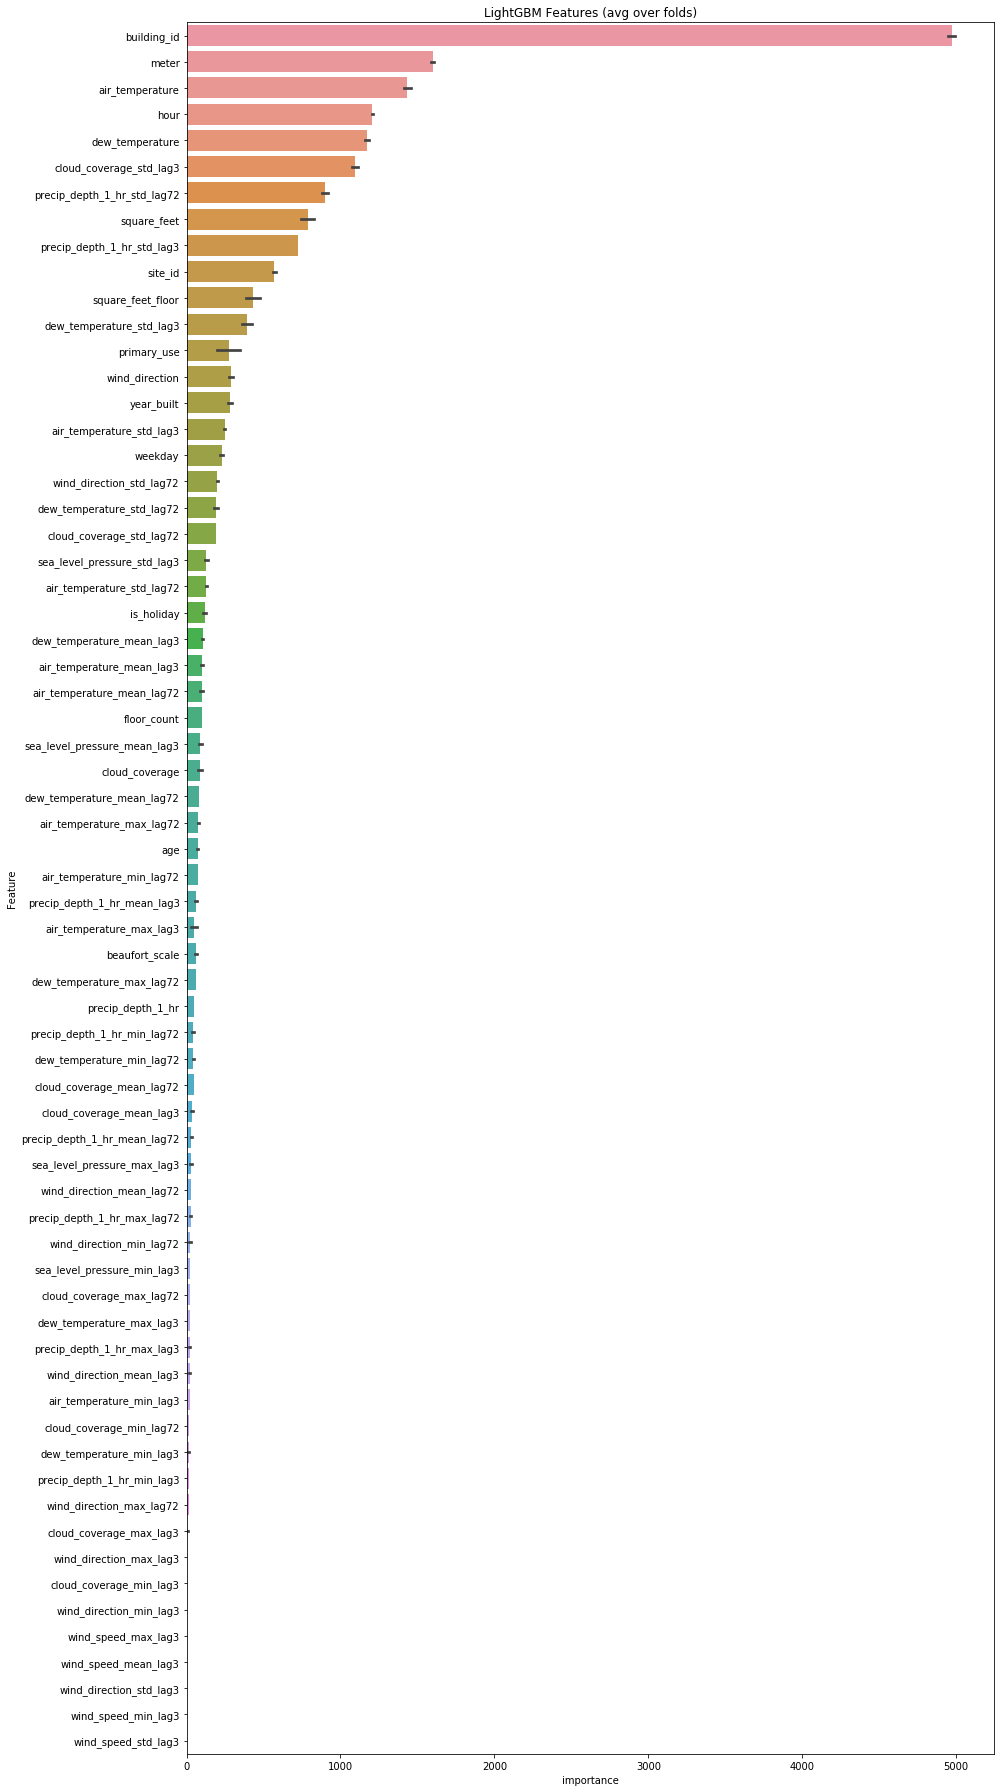

In [12]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('result/lgbm_importances.png')

## Preparing test data for prediction

In [13]:
feat_cols

['site_id',
 'building_id',
 'primary_use',
 'hour',
 'weekday',
 'meter',
 'wind_direction',
 'is_holiday',
 'primary_use',
 'square_feet',
 'year_built',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'floor_count',
 'beaufort_scale',
 'age',
 'square_feet_floor',
 'air_temperature_mean_lag3',
 'air_temperature_max_lag3',
 'air_temperature_min_lag3',
 'air_temperature_std_lag3',
 'cloud_coverage_mean_lag3',
 'cloud_coverage_max_lag3',
 'cloud_coverage_min_lag3',
 'cloud_coverage_std_lag3',
 'dew_temperature_mean_lag3',
 'dew_temperature_max_lag3',
 'dew_temperature_min_lag3',
 'dew_temperature_std_lag3',
 'precip_depth_1_hr_mean_lag3',
 'precip_depth_1_hr_max_lag3',
 'precip_depth_1_hr_min_lag3',
 'precip_depth_1_hr_std_lag3',
 'sea_level_pressure_mean_lag3',
 'sea_level_pressure_max_lag3',
 'sea_level_pressure_min_lag3',
 'sea_level_pressure_std_lag3',
 'wind_direction_mean_lag3',
 'wind_direction_max_lag3',
 'wind_direction_min_lag3',
 'wind_direc

In [14]:
full_test_df.columns

Index(['row_id', 'building_id', 'meter', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'offset', 'age',
       'hour', 'day', 'weekday', 'month', 'year', 'square_feet_floor',
       'air_temperature_mean_lag3', 'air_temperature_max_lag3',
       'air_temperature_min_lag3', 'air_temperature_std_lag3',
       'cloud_coverage_mean_lag3', 'cloud_coverage_max_lag3',
       'cloud_coverage_min_lag3', 'cloud_coverage_std_lag3',
       'dew_temperature_mean_lag3', 'dew_temperature_max_lag3',
       'dew_temperature_min_lag3', 'dew_temperature_std_lag3',
       'precip_depth_1_hr_mean_lag3', 'precip_depth_1_hr_max_lag3',
       'precip_depth_1_hr_min_lag3', 'precip_depth_1_hr_std_lag3',
       'sea_level_pressure_mean_lag3', 'sea_level_pressure_max_lag3',
       'sea_level_pressure_min_lag3', 'sea_level_pressure_std_lag3'

In [15]:
full_test_df = pd.read_pickle('tmp/full_test_df.pkl')
full_test_df = full_test_df[feat_cols]

## Prediction for test data

In [16]:
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(full_test_df.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(full_test_df.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

100%|██████████| 834/834 [13:40<00:00,  1.04s/it]


In [17]:
res = np.concatenate(res)

## Submission for competition

In [18]:
submission = pd.read_csv('data/sample_submission.csv')
submission['meter_reading'] = res
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('result/submission_fe_lgbm_ft_eng_20191003.csv', index=False)
submission

,row_id,meter_reading
0,0,203.320820
1,1,101.636268
2,2,6.415377
3,3,223.439455
4,4,1456.100176
...,...,...
41697595,41697595,5.993533
41697596,41697596,4.093212
41697597,41697597,3.516566
41697598,41697598,157.620172
